In [ ]:
import jax.numpy as jnp
from jax import random, vmap, lax
from jax.nn import sigmoid, tanh
from functools import partial
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def simulate_logistic(T, x0=0.2, r=3.7):
    x = np.zeros(T); x[0] = x0
    for t in range(T-1):
        x[t+1] = r * x[t] * (1 - x[t])
    return x

def simulate_mackey_glass(T, tau=17, beta=0.2, gamma=0.1, n=10, x0=1.2):
    x = np.zeros(T + tau)
    x[:tau+1] = x0
    for t in range(tau, T + tau - 1):
        x[t+1] = x[t] + (beta * x[t - tau] / (1 + x[t - tau]**n) - gamma * x[t])
    return x[tau:]  


In [ ]:
import numpy as np


def ridge_readout(Y, series_norm, k=1, lam=1, train_ratio=0.7):

    T, N = Y.shape
    if series_norm.ndim == 1:
        series_norm = series_norm[:, None] 
    M = series_norm.shape[1]

    A = Y[:-k].astype(np.float64)            # (T-k, N)
    Yt = series_norm[k:].astype(np.float64)  # (T-k, M)

    # Bias + split
    A1 = np.hstack([A, np.ones((A.shape[0], 1))])  # (T-k, N+1)
    split = int(train_ratio * A1.shape[0])
    Atr, Ytr = A1[:split], Yt[:split]

    #ridge
    G = Atr.T @ Atr
    G.flat[::G.shape[0]+1] += lam
    Theta = np.linalg.solve(G, Atr.T @ Ytr)  # (N+1, M)

    # forecast
    Y_pred = A1 @ Theta                      # (T-k, M)
    return Y_pred[:split], Y_pred[split:]





In [ ]:

def define_pars(key, hidden_size, input_dim,
                bias_scale, vol, normalize=False):

    kW_i,kW_f,kW_c,kW_o, kU_i,kU_f,kU_c,kU_o, kb_i, kb_f, kb_o = random.split(key, 11)

    h_scale = vol / jnp.sqrt(hidden_size) if normalize else vol
    x_scale = vol / jnp.sqrt(input_dim)   if normalize else vol

    def randW(k, in_dim, out_dim, scl):
        return random.normal(k, (in_dim, out_dim)) * scl

    W_i = randW(kW_i, hidden_size, hidden_size, h_scale)
    W_f = randW(kW_f, hidden_size, hidden_size, h_scale)
    W_c = randW(kW_c, hidden_size, hidden_size, h_scale)
    W_o = randW(kW_o, hidden_size, hidden_size, h_scale)

    U_i = randW(kU_i, input_dim, hidden_size, x_scale)
    U_f = randW(kU_f, input_dim, hidden_size, x_scale)
    U_c = randW(kU_c, input_dim, hidden_size, x_scale)
    U_o = randW(kU_o, input_dim, hidden_size, x_scale)

    b_i = random.normal(kb_i, (hidden_size,)) * bias_scale
    b_f = random.normal(kb_f, (hidden_size,)) * bias_scale
    b_c = jnp.zeros((hidden_size,))
    b_o = random.normal(kb_o, (hidden_size,)) * bias_scale

    return W_i,W_f,W_c,W_o, U_i,U_f,U_c,U_o, b_i,b_f,b_c,b_o


def single_lstm_cell(key, x_seq,
                     hidden_size, bias_scale,
                     vol, normalize=False):

    T, input_dim = x_seq.shape
    pars = define_pars(key, hidden_size, input_dim,
                       bias_scale, vol, normalize)

    (W_i,W_f,W_c,W_o, U_i,U_f,U_c,U_o,
     b_i,b_f,b_c,b_o) = pars

    h0 = random.normal(key, (hidden_size,))
    c0 = jnp.zeros(hidden_size)

    def f_scan(carry, x_t):
        h, c = carry
        i = jnn.sigmoid(h @ W_i + x_t @ U_i + b_i)
        f = jnn.sigmoid(h @ W_f + x_t @ U_f + b_f)
        o = jnn.sigmoid(h @ W_o + x_t @ U_o + b_o)
        c_hat = jnp.tanh(h @ W_c + x_t @ U_c + b_c)
        c = f * c + i * c_hat
        h = o * jnp.tanh(c)
        return (h, c), h

    (h_T, c_T), h_seq = lax.scan(f_scan, (h0, c0), x_seq)
    return (h_T, c_T), h_seq


def LSTMCell_test(keys, x_seq,
                  hidden_size, bias_scale,
                  vol, normalize=False):
  
    cell_fixed = partial(single_lstm_cell,
                         x_seq=x_seq,
                         hidden_size=hidden_size,
                         bias_scale=bias_scale,
                         vol=vol,
                         normalize=normalize)

    # parallelizing
    _, h_seq = jax.vmap(cell_fixed)(keys)
    return h_seq



In [ ]:

from sklearn.decomposition import PCA
num_steps = 1000 
r, x0 = 3.8, 0.21
M = 1 
 
#PARAMETERS
tau   = 45
beta  = 0.2
gamma = 0.06    
n     = 10
x0    = 1.2


series_raw = np.stack([
    simulate_mackey_glass(
        num_steps,
        tau=int(tau + np.random.uniform(-1, 1)),   
        beta=beta + np.random.uniform(-0.02, 0.02),
        gamma=0.06,
        n=10,
        x0=x0 + 0.1 * np.random.uniform(0, 0.4)
    )
    for _ in range(M)
], axis=1)


factor = 0.25
x_mean, x_std = series_raw.mean(0), series_raw.std(0)
x_scaled = factor*(series_raw - x_mean) / x_std     # (T, M)

x_seq = jnp.asarray(x_scaled)


# PLOT SINGLE-SERIES

/opt/anaconda3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


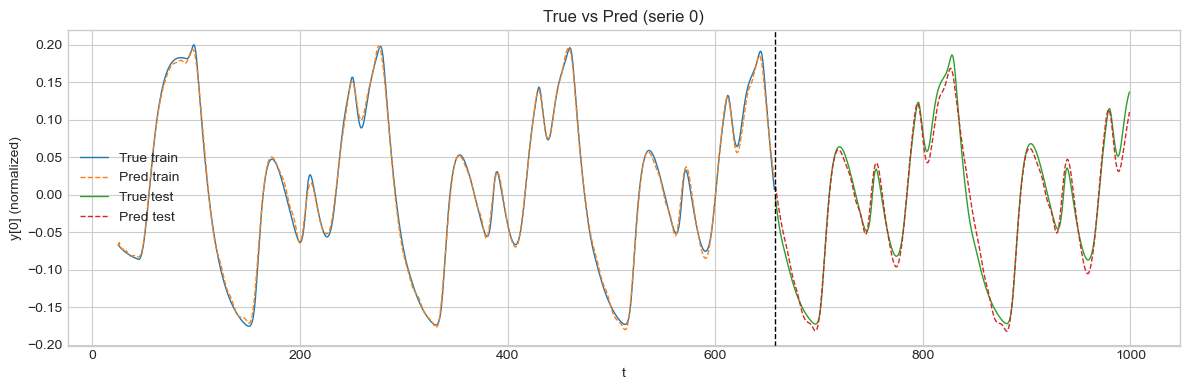

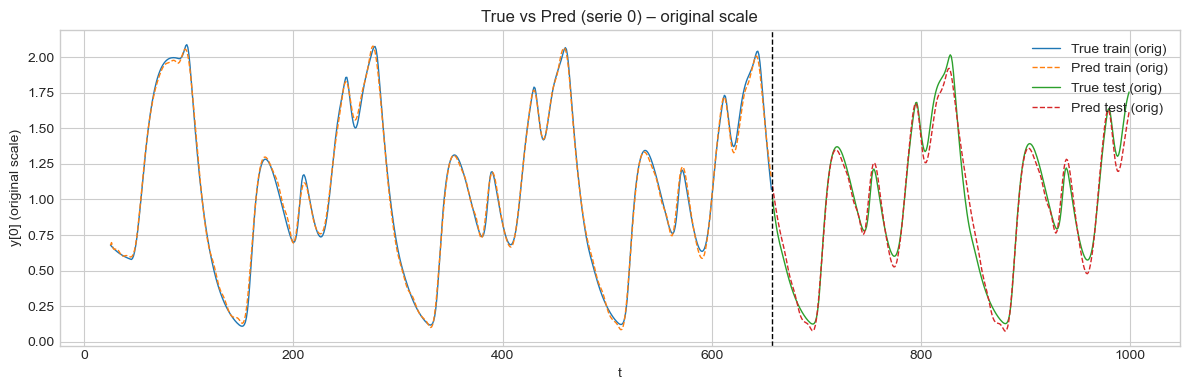

In [ ]:
key = random.PRNGKey(0)
hidden_size = 1000
g = 2
bias = 0
k = 25

_, Y = single_lstm_cell(key, x_seq, hidden_size, bias, g, normalize=True)

yhat_tr, yhat_te = ridge_readout(Y, x_seq, k=k, train_ratio=0.65)


idx = 0  # which series

y = x_seq[k:, idx]             
split = yhat_tr.shape[0]
t = np.arange(k, k + len(y))
x_split = t[split]

y_orig = y * x_std / factor + x_mean

yhat_tr_orig = yhat_tr[:, idx] * x_std / factor + x_mean
yhat_te_orig = yhat_te[:, idx] * x_std / factor + x_mean


plt.figure(figsize=(12,4))
plt.plot(t[:split], y_orig[:split],       lw=1, label='True train (orig)')
plt.plot(t[:split], yhat_tr_orig,         lw=1, linestyle='--', label='Pred train (orig)')
plt.plot(t[split:], y_orig[split:],       lw=1, label='True test (orig)')
plt.plot(t[split:], yhat_te_orig,         lw=1, linestyle='--', label='Pred test (orig)')
plt.axvline(x=x_split, linestyle='--', linewidth=1, color='k')

plt.xlabel('t')
plt.ylabel(f'y[{idx}] (original scale)')
plt.title(f'True vs Pred (serie {idx}) – original scale')
plt.legend(loc='best')
plt.tight_layout()
plt.show()



# FINITE SIZE EFFECT

In [ ]:
MSE_in_N = []
MSE_out_N = []
ERR_in_N = []
ERR_out_N = []

k = 25  # horizon
v = np.linspace(0.5, 3, 31)
N_vals =  [400, 800, 1200]
bias = 0
n_runs = 10

for hidden_size in N_vals:
    mse_in_list, mse_out_list = [], []
    err_in_list, err_out_list = [], []

    for value in v:
        g = 2
        g_i = g * value

        mse_in_runs, mse_out_runs = [], []

        for run in range(n_runs):
            key = random.PRNGKey(run)
            _, Y = single_lstm_cell(key, x_seq, hidden_size, bias, g_i, normalize=True)
            yhat_tr, yhat_te = ridge_readout(Y, x_seq, k=k, lam=1, train_ratio=0.7)

            y_true     = x_seq[k:] * x_std / factor + x_mean
            yhat_tr = yhat_tr * x_std / factor + x_mean
            yhat_te = yhat_te * x_std / factor + x_mean

            split = yhat_tr.shape[0]

            mse_in = np.mean((y_true[:split] - yhat_tr) ** 2)
            mse_out = np.mean((y_true[split:] - yhat_te) ** 2)

            mse_in_runs.append(mse_in)
            mse_out_runs.append(mse_out)

        # CI 0.95
        mse_in_runs = np.array(mse_in_runs)
        mse_out_runs = np.array(mse_out_runs)

        mean_in, mean_out = mse_in_runs.mean(), mse_out_runs.mean()
        err_in = 1.96 * mse_in_runs.std(ddof=1) / np.sqrt(n_runs)
        err_out = 1.96 * mse_out_runs.std(ddof=1) / np.sqrt(n_runs)

        mse_in_list.append(mean_in)
        mse_out_list.append(mean_out)
        err_in_list.append(err_in)
        err_out_list.append(err_out)

    MSE_in_N.append(mse_in_list)
    MSE_out_N.append(mse_out_list)
    ERR_in_N.append(err_in_list)
    ERR_out_N.append(err_out_list)


    

/opt/anaconda3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


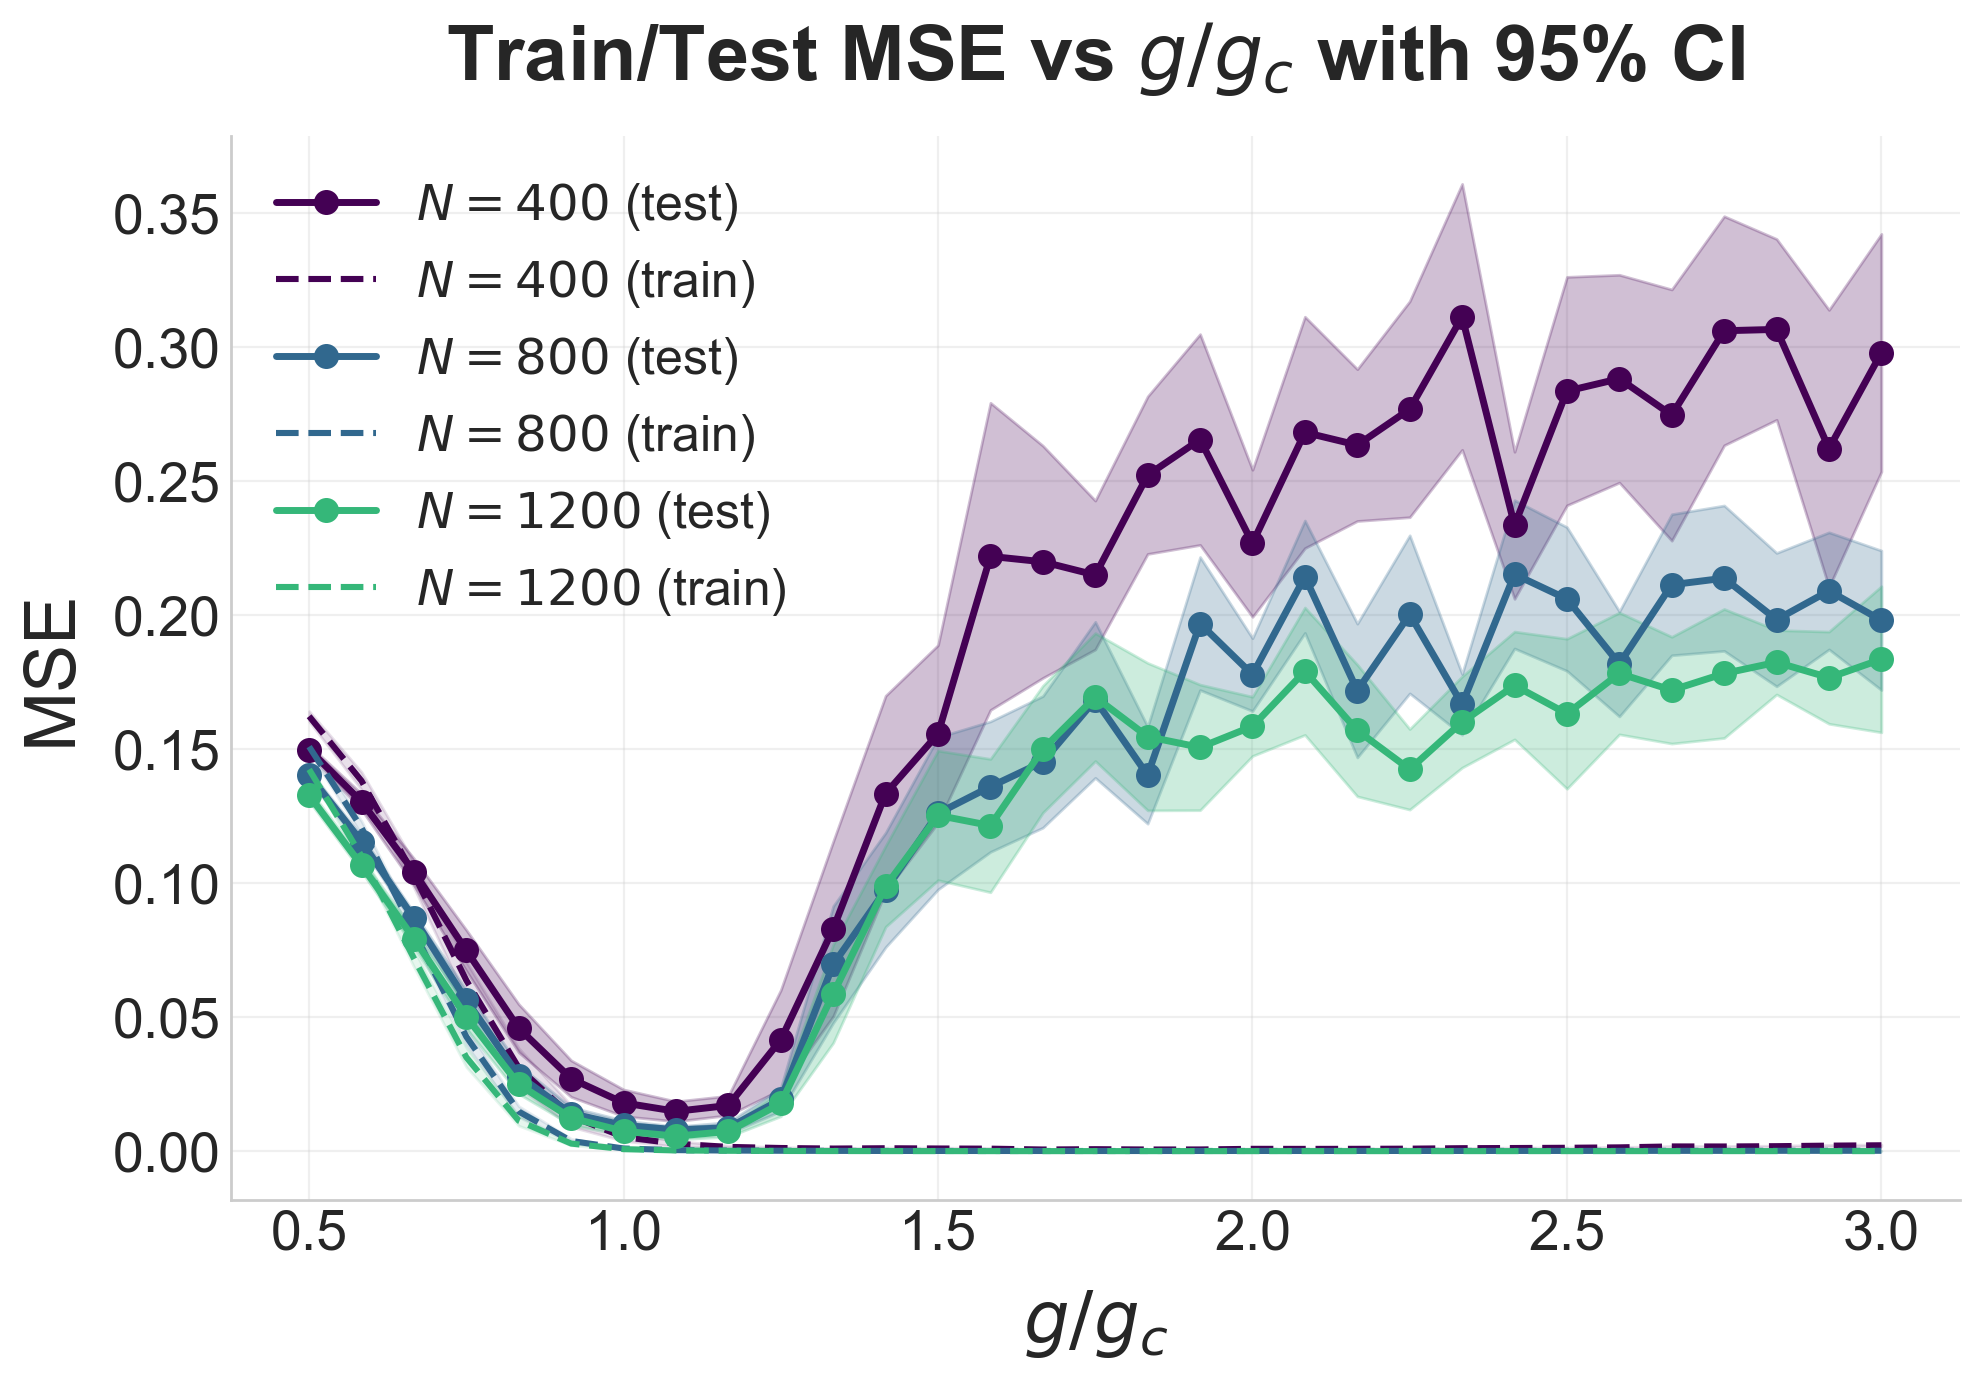

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

MSE_in_N = np.array(MSE_in_N)
MSE_out_N = np.array(MSE_out_N)
ERR_in_N = np.array(ERR_in_N)
ERR_out_N = np.array(ERR_out_N)

plt.figure(figsize=(10, 7), dpi=600)
plt.style.use("seaborn-v0_8-whitegrid")

for i, N in enumerate(N_vals):
    color = plt.cm.viridis(i / len(N_vals))

    plt.plot(v, MSE_out_N[i], color=color, marker='o', linewidth=2.5, markersize=8,
             label=fr'$N = {N}$ (test)')
    plt.fill_between(v,
                     MSE_out_N[i] - ERR_out_N[i],
                     MSE_out_N[i] + ERR_out_N[i],
                     color=color, alpha=0.25)

    plt.plot(v, MSE_in_N[i], linestyle='--', color=color, linewidth=2.2,
             label=fr'$N = {N}$ (train)')
    plt.fill_between(v,
                     MSE_in_N[i] - ERR_in_N[i],
                     MSE_in_N[i] + ERR_in_N[i],
                     color=color, alpha=0.12)

plt.xlabel(r"$g / g_c$", fontsize=26, labelpad=10)
plt.ylabel("MSE", fontsize=26, labelpad=10)
plt.title("Train/Test MSE vs $g / g_c$ with 95% CI", fontsize=28, pad=20, weight='bold')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.grid(True, alpha=0.3)
plt.legend(fontsize=18, frameon=False, loc='upper left')

ax = plt.gca()
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()




# HEATMAP WITH BIAS

In [ ]:
k = 25                          
v = np.linspace(0.4, 1.4, 50)   
bias_vals = np.linspace(0,1,20)   
hidden_size = 1000 #1000
n_runs = 30

heatmap = np.zeros((len(bias_vals), len(v)))



for bi, bias in enumerate(bias_vals):
    for gi, value in enumerate(v):

        g = 2.0
        g_i = g * value

        mse_runs = []

        for run in range(n_runs):
            key = random.PRNGKey(run)

            _, Y = single_lstm_cell(
                key,
                x_seq,
                hidden_size,
                bias,
                g_i,
                normalize=True
            )

            yhat_tr, yhat_te = ridge_readout(
                Y,
                x_seq,
                k=k,
                lam=1,
                train_ratio=0.7
            )

            y_true = x_seq[k:]
            split = yhat_tr.shape[0]

            mse_out = np.mean((y_true[split:] - yhat_te)**2)
            mse_runs.append(mse_out)

        mse_out_mean = np.mean(mse_runs)
        heatmap[bi, gi] = mse_out_mean  




# RANDOM MATRIX THEORY

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

rng = np.random.default_rng(4)

sigma_list = np.linspace(0, 1, 30)
N = 300_000
g_c = []

for sigma in sigma_list:
    A_vals = sigmoid(rng.normal(loc=0.0, scale=sigma, size=N))
    L_vals = sigmoid(rng.normal(loc=0.0, scale=sigma, size=N))
    R_vals = sigmoid(rng.normal(loc=0.0, scale=sigma, size=N))


    gc_inv_sq = np.mean((L_vals * R_vals)**2 / (1.0 - A_vals)**2)
    g_c.append(gc_inv_sq ** (-0.5))   

g_c = np.array(g_c)


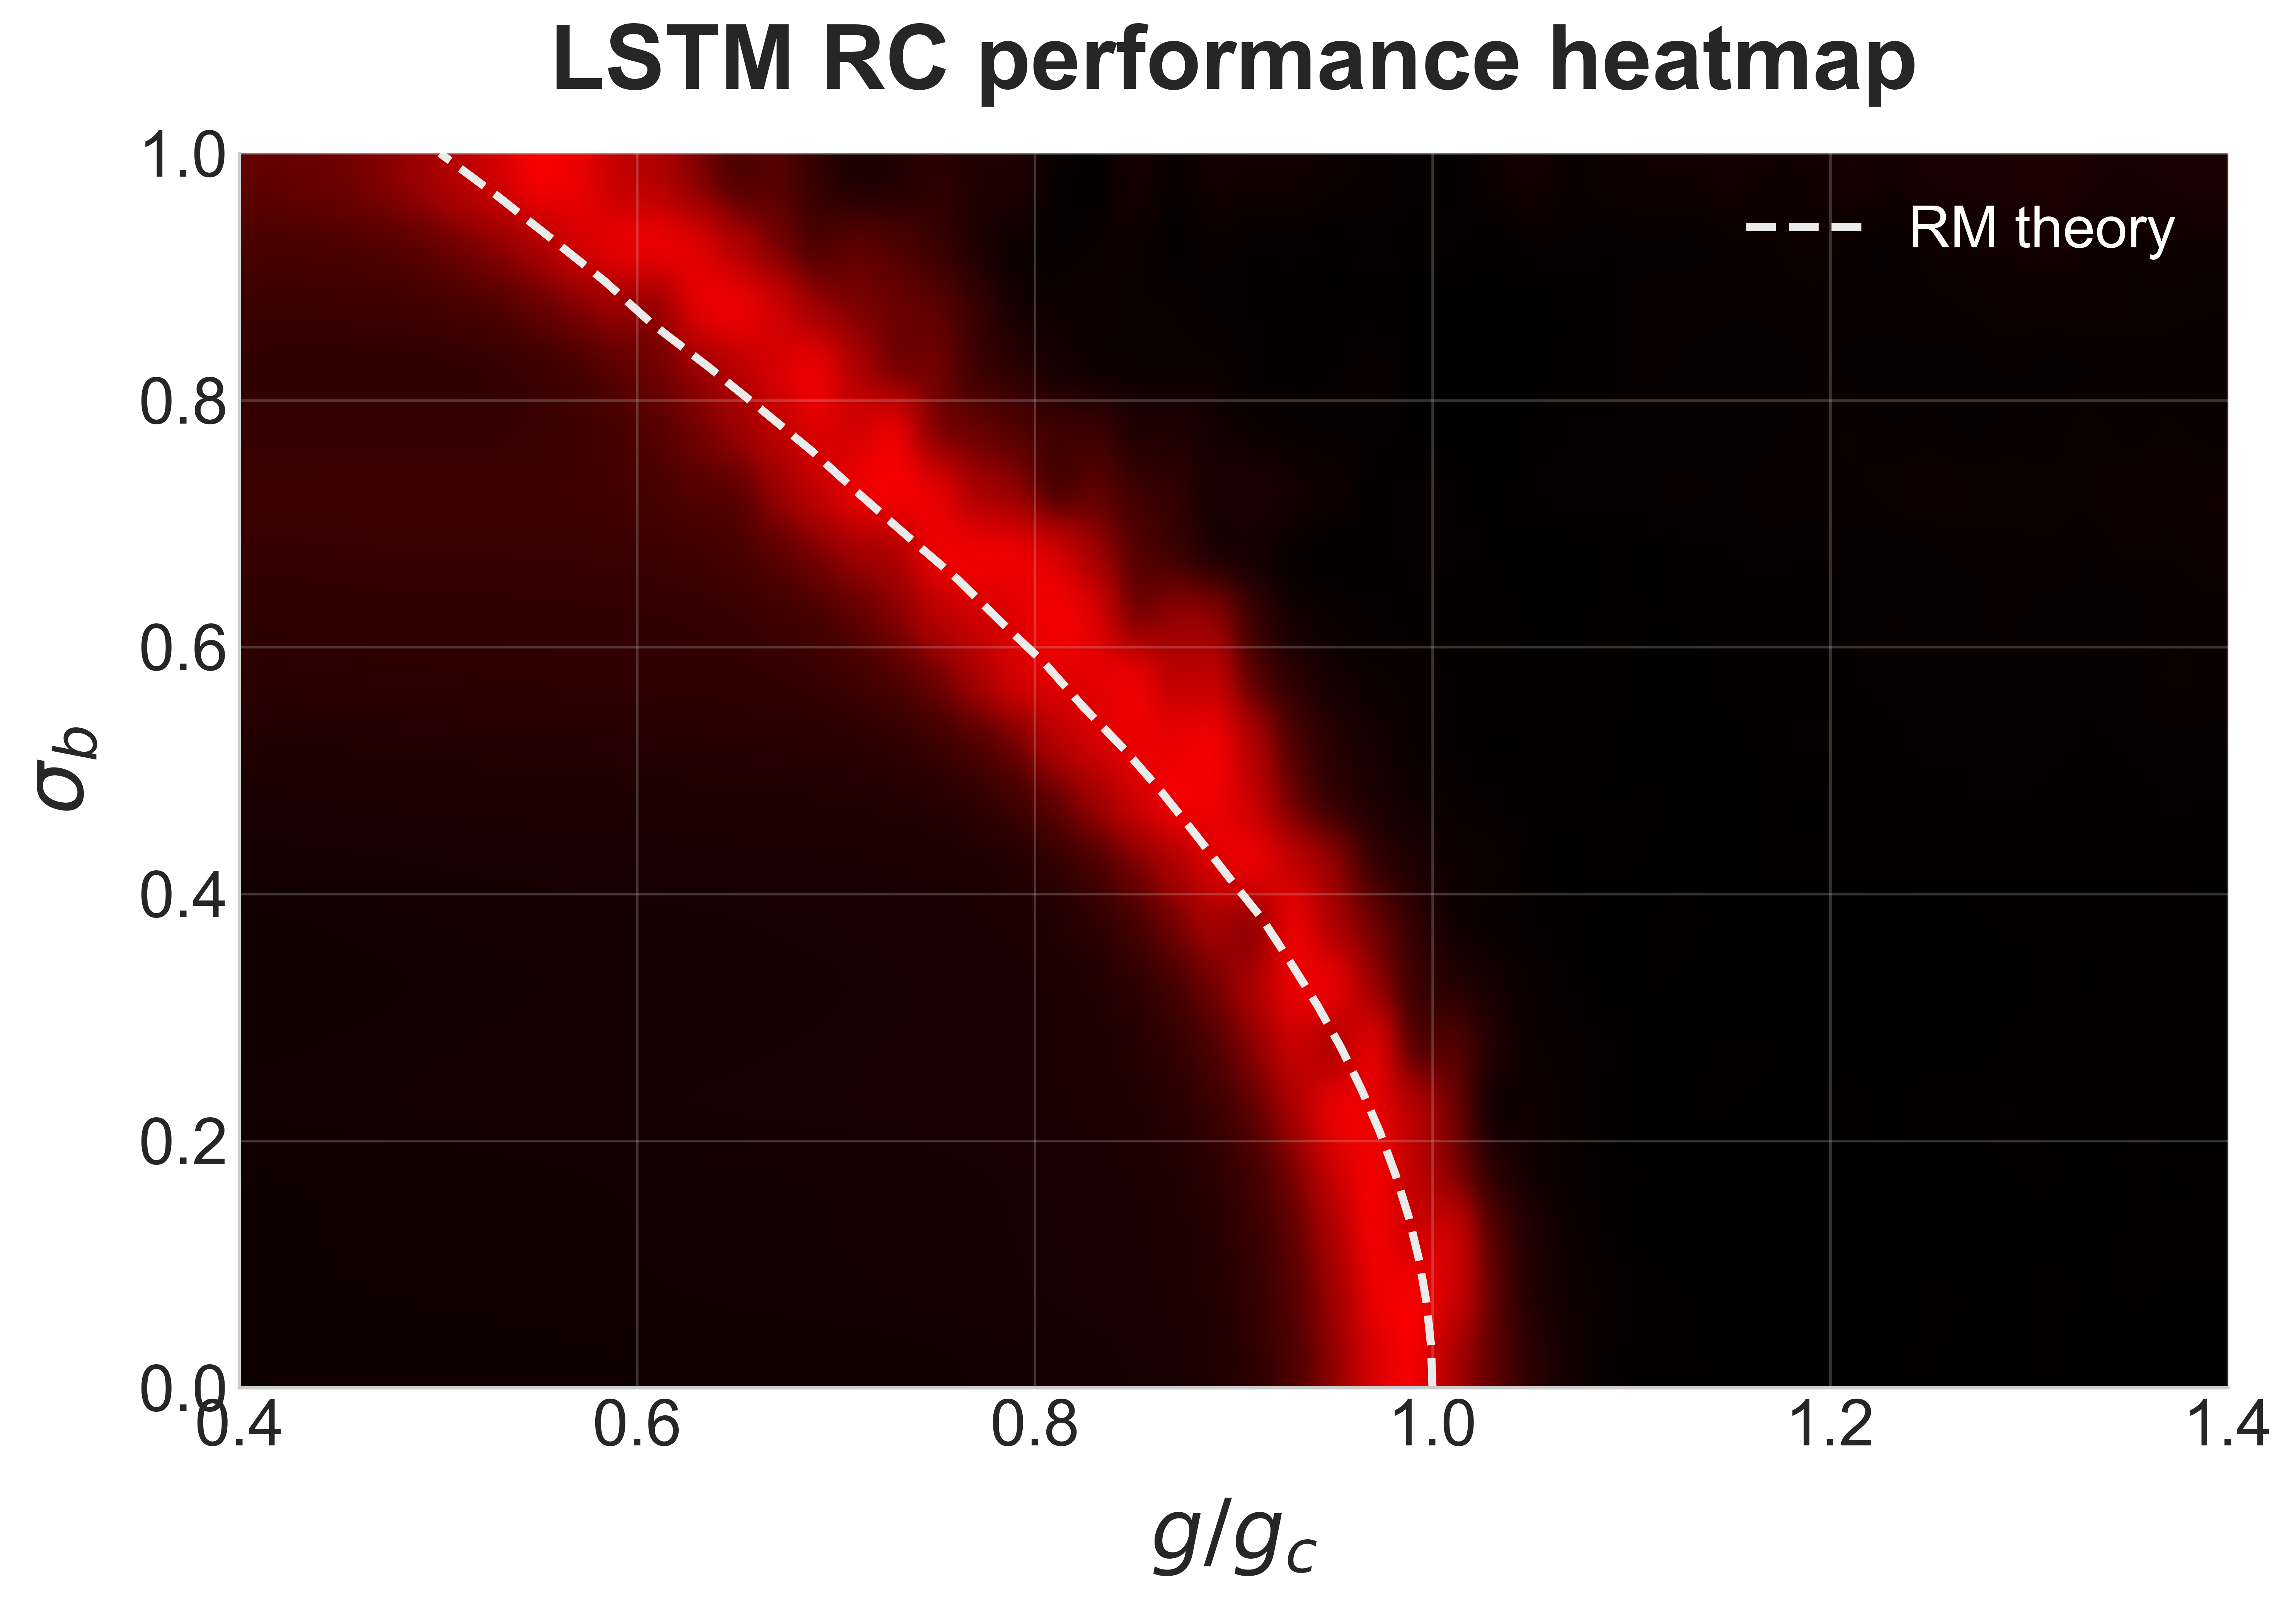

<Figure size 640x480 with 0 Axes>

In [ ]:
from matplotlib.colors import LinearSegmentedColormap, PowerNorm

norm_heatmap = 1 / heatmap

mins = norm_heatmap.min(axis=1, keepdims=True)
maxs = norm_heatmap.max(axis=1, keepdims=True)

heatmap_norm = (norm_heatmap - mins) / (maxs - mins)

redmap = LinearSegmentedColormap.from_list(
    "black_to_red",
    [
        (0.0, 0.0, 0.0),
        (0.6, 0.0, 0.0),
        (1.0, 0.0, 0.0),
    ]
)

fig, ax = plt.subplots(figsize=(10, 7), dpi=600)

im = ax.imshow(
    heatmap_norm,
    cmap=redmap,
    vmin=0,
    vmax=1,
    interpolation='gaussian',
    aspect='auto',
    origin='lower',
    extent=[v.min(), v.max(), bias_vals[0], bias_vals[-1]],
)

# theoretical curve
ax.plot(
    g_c/2,
    sigma_list,
    color=(0.92, 0.92, 0.92),
    linewidth=2.5,
    linestyle='--',
    label=r"RM theory",
)

ax.set_xlabel(r"$g/g_c$", fontsize=26, fontweight='bold', labelpad=12)
ax.set_ylabel(r"$\sigma_b$", fontsize=26, fontweight='bold', labelpad=12)
ax.set_title("LSTM RC performance heatmap", fontsize=28, fontweight='bold', pad=20)

ax.tick_params(axis='both', labelsize=20, width=1.2)

ax.grid(True, alpha=0.25)

ax.legend(
    loc='upper right',
    frameon=False,
    fontsize=18,
    labelcolor="white"
)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.savefig("RC_heatmap.pdf", dpi=600, bbox_inches="tight")
plt.show()

plt.tight_layout()
plt.show()
